# Analyzing Open Jobs in NYC City Government

NYC Open Data has released a list of all the open jobs in the city of New York. I downloaded the data in CSV form [here](https://data.cityofnewyork.us/Business/NYC-Jobs/kpav-sd4t).

My goal is to answer the following questions:

1. Who has the most openings?
2. Which departments have the highest and the lowest paying positions (based on current job openings)?
3. Which jobs do you think are the hardest to fill? (What makes you say that?)

Some info to consider that isn't immediately apparent from the dataset at first glance:
* Some rows of job listings represent more than one available position with that job title. This is indicated anytime the column "# Of Positions" is > 1. This is important for calculating the answer to question 1.
* Some rows of job listings have exactly the same Job ID and information, except that one has a Posting Type of Internal and the other External. We should not count these as two separate positions when answering the first two questions, since they technically represent the same job opening that was posted to two different outlets.
* The column "Salary Frequency" can be Hourly, Daily or Annual. This should be factored into our investigation of question 2.

OK, let's get started!

In [1]:
%matplotlib inline 

import math
import pandas as pd
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
from collections import defaultdict


nyc_jobs = pd.read_csv('NYC_Jobs.csv', encoding='utf-8')
nyc_jobs.columns = ['Job ID','Agency','Posting Type','# Of Positions','Business Title','Civil Service Title','Title Code No',
'Level','Salary Range From','Salary Range To','Salary Frequency','Work Location','Division/Work Unit','Job Description',
'Minimum Qual Requirements','Preferred Skills','Additional Information','To Apply','Hours/Shift','Work Location 1','Recruitment Contact',
'Residency Requirement','Posting Date','Post Until','Posting Updated','Process Date']

Let's test it out by printing out the first 3 rows.

In [2]:
nyc_jobs[:3]
#check data types of each column
#nyc_jobs.dtypes

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Salary Range From,Salary Range To,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,167179,NYC EMPLOYEES RETIREMENT SYS,Internal,1,"CERTIFIED IT ADMINISTRATOR (WAN), Level 4",CERT. IT ADMINISTRATOR WAN,13642,04,87203,131623,...,,To apply please click the ''apply now'' button...,,,NaN,New York City Residency is not required for th...,11/19/2014 00:00:00,NaN,11/19/2014 00:00:00,02/23/2016 00:00:00
1,167179,NYC EMPLOYEES RETIREMENT SYS,External,1,"CERTIFIED IT ADMINISTRATOR (WAN), Level 4",CERT. IT ADMINISTRATOR WAN,13642,04,87203,131623,...,,To apply please click the ''apply now'' button...,,,NaN,New York City Residency is not required for th...,11/19/2014 00:00:00,NaN,11/19/2014 00:00:00,02/23/2016 00:00:00
2,168165,DEPT OF HEALTH/MENTAL HYGIENE,External,1,"Project Coordinator, District Public Health Br...",ADMINISTRATIVE STAFF ANALYST (,1002A,00,56937,88649,...,,Apply online with a cover letter to https://a1...,,"485 Throop Avenue, Brooklyn, NY, 11221",NaN,New York City residency is generally required ...,09/18/2014 00:00:00,NaN,09/18/2014 00:00:00,02/23/2016 00:00:00


Notice something interesting about the above? Rows 0 and 1 are the exact same listing (Job ID is the same). The only difference is that one is an internal listing and one is external (see posting type column). We should not count these as 2 separate openings. How do we avoid counting these as two separate postings? 

Let's check if all external postings have already been posted internally.

In [3]:
internal_ids = nyc_jobs[nyc_jobs['Posting Type'] == 'Internal']['Job ID']
external_ids = nyc_jobs[nyc_jobs['Posting Type'] == 'External']['Job ID']

external_only = set(external_ids) - set(internal_ids)
external_only_df = nyc_jobs[nyc_jobs['Job ID'].isin(external_only)]
external_only_df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Salary Range From,Salary Range To,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
35,151131,NYC HOUSING AUTHORITY,External,1,Cost Estimating Manager,ADMINISTRATIVE STAFF ANALYST (,1002D,00,90000,110000,...,SPECIAL INSTRUCTIONS FOR NYCHA EMPLOYEES: N...,Click the ''Apply Now'' button.,,,NaN,NYCHA has no residency requirements.,06/25/2014 00:00:00,NaN,07/07/2014 00:00:00,02/23/2016 00:00:00
119,163183,DEPT OF ENVIRONMENT PROTECTION,External,1,Per Diem - Remote Learning Team Specialist,COMPUTER PROGRAMMER ANALYST,13651,01,24,33,...,,Click the ''apply now'' button.,,59-17 Junction Blvd Corona Ny,NaN,New York City Residency is not required for th...,08/27/2014 00:00:00,NaN,08/27/2014 00:00:00,02/23/2016 00:00:00
1067,209312,DEPARTMENT OF TRANSPORTATION,External,2,Deputy Queens Borough Commissioner - 2 positions,CONFIDENTIAL STRATEGY PLANNER,54738,00,52808,88890,...,MINIMUM QUALIFICATION REQUIREMENTS: A baccalau...,All resumes are to be submitted electronically...,,,NaN,New York City residency is generally required ...,08/26/2015 00:00:00,NaN,09/16/2015 00:00:00,02/23/2016 00:00:00
1500,217474,HOUSING PRESERVATION & DVLPMNT,External,1,Environmental Planner,CITY PLANNER,22122,01,49897,65000,...,,Apply Online,,100 Gold Street,NaN,New York City residency is generally required ...,10/05/2015 00:00:00,NaN,10/05/2015 00:00:00,02/23/2016 00:00:00
3568,231079,HOUSING PRESERVATION & DVLPMNT,External,1,Assistant Architect,ASSISTANT ARCHITECT,21210,00,51586,77404,...,,NaN,,100 Gold Street,NaN,New York City Residency is not required for th...,02/09/2016 00:00:00,NaN,02/09/2016 00:00:00,02/23/2016 00:00:00


Looks like 5 job IDs are posted externally, but not internally. Interesting.

Let's use drop_duplicates('Job ID') to make sure listings that appear twice only appear once in our dataframe.

In [4]:
df2 = nyc_jobs.copy()
#drop columns where value is null
df2 = df2.dropna(axis=1, how='any')

df2 = df2.drop_duplicates('Job ID')
df2.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Salary Range From,Salary Range To,...,Division/Work Unit,Job Description,Preferred Skills,Additional Information,Hours/Shift,Work Location 1,Residency Requirement,Posting Date,Posting Updated,Process Date
0,167179,NYC EMPLOYEES RETIREMENT SYS,Internal,1,"CERTIFIED IT ADMINISTRATOR (WAN), Level 4",CERT. IT ADMINISTRATOR WAN,13642,04,87203,131623,...,Executive Management,"Oversees the design, installation, configurati...","Minimum 5 years of experience planning, design...",,,,New York City Residency is not required for th...,11/19/2014 00:00:00,11/19/2014 00:00:00,02/23/2016 00:00:00
2,168165,DEPT OF HEALTH/MENTAL HYGIENE,External,1,"Project Coordinator, District Public Health Br...",ADMINISTRATIVE STAFF ANALYST (,1002A,00,56937,88649,...,District Public Health Brklyn,The Brooklyn District Public Health Office (DP...,Master's degree in public health or equivalent...,,,"485 Throop Avenue, Brooklyn, NY, 11221",New York City residency is generally required ...,09/18/2014 00:00:00,09/18/2014 00:00:00,02/23/2016 00:00:00
3,149599,DEPT OF ENVIRONMENT PROTECTION,External,1,Construction Project Manager Intern,CONSTRUCTION PROJECT MANAGER I,34201,00,43349,52496,...,JOCS- IFA,"Working within Capital Coordination, under dir...",,Appointments are subject to OMB approval. For...,35 Hours per Week,,New York City residency is generally required ...,04/25/2014 00:00:00,04/25/2014 00:00:00,02/23/2016 00:00:00
5,149908,DEPARTMENT OF BUILDINGS,External,3,Senior Application Developer,COMPUTER SYSTEMS MANAGER,10050,M1,49492,100000,...,Information Technology,The NYC Department of Buildings (Ã¢â¬ÅDOBÃ¢â...,Ã¢â¬Â¢7+ years substantive hands-on applicati...,,35 hours (minimum),"280 Broadway, 6th Floor, N.Y.",New York City Residency is not required for th...,04/03/2015 00:00:00,04/03/2015 00:00:00,02/23/2016 00:00:00
7,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,01,42405,65485,...,Strategy & Analytics,Division of Economic & Financial Opportunity (...,Ã¢â¬Â¢\tExcellent interpersonal and organizat...,"Salary range for this position is: $42,405 - $...",,,New York City residency is generally required ...,06/24/2011 00:00:00,06/24/2011 00:00:00,02/23/2016 00:00:00


## Which Agency has the Highest Number of Job Openings?

On first glance, the value_counts() method seems to give us the answer quite nicely.

In [5]:
#The below gets agency with highest number of job postings, but doesn't account for postings with # Of Positions > 1; 
#we should include these in the total count
df2['Agency'].value_counts()

DEPT OF HEALTH/MENTAL HYGIENE     630
DEPT OF ENVIRONMENT PROTECTION    217
DEPT OF DESIGN & CONSTRUCTION     134
DEPT OF INFO TECH & TELECOMM      123
ADMIN FOR CHILDREN'S SVCS         100
DEPARTMENT OF BUILDINGS            93
HOUSING PRESERVATION & DVLPMNT     80
DEPARTMENT OF INVESTIGATION        73
DEPARTMENT OF TRANSPORTATION       73
DEPARTMENT OF CORRECTION           61
DEPARTMENT OF SANITATION           53
HRA/DEPT OF SOCIAL SERVICES        49
DEPARTMENT OF FINANCE              47
NYC HOUSING AUTHORITY              32
DEPT OF PARKS & RECREATION         32
FIRE DEPARTMENT                    32
DEPARTMENT OF BUSINESS SERV.       31
ADMIN TRIALS AND HEARINGS          22
DEPT OF CITYWIDE ADMIN SVCS        19
CONSUMER AFFAIRS                   16
LAW DEPARTMENT                     16
TAXI & LIMOUSINE COMMISSION        14
DEPT OF YOUTH & COMM DEV SRVS      14
FINANCIAL INFO SVCS AGENCY         14
DEPT. OF HOMELESS SERVICES         13
DEPARTMENT FOR THE AGING           11
CIVILIAN COM

From the above, it looks like the Department of Health/Mental Hygiene has the most openings. But wait! Remember that sneaky "# Of Postings" column? We have to count those, too, right?

In [6]:
#As shown below, # Of Positions prints anywhere from 1 to 100
print df2['# Of Positions'].unique()
#[  1   3   5  52   4   2  50  11  30   6   8  15  10  12  20  16   9   7
#  25  69  75  67  14  17  71  13 100 107  39  18  28]

[  1   3   5  52   4   2  50  11  30   6   8  15  10  12  20  16   9   7
  25  69  75  67  14  17  71  13 100 107  39  18  28]


The unique() method has revealed that "# Of Positions" can be anywhere from 1 to 107. Let's make sure we count the rows with "# Of Positions > 1" as the true number of postings they represent.

In [7]:
by_agency = df2.groupby('Agency')
by_agency['# Of Positions'].sum().sort_values(ascending=False)

Agency
DEPT OF HEALTH/MENTAL HYGIENE     1382
DEPT OF DESIGN & CONSTRUCTION      598
DEPARTMENT OF BUILDINGS            484
DEPT OF ENVIRONMENT PROTECTION     360
ADMIN FOR CHILDREN'S SVCS          275
DEPT OF PARKS & RECREATION         200
NYC HOUSING AUTHORITY              185
DEPARTMENT OF TRANSPORTATION       182
DEPARTMENT OF CORRECTION           178
DEPT OF INFO TECH & TELECOMM       162
DEPARTMENT OF INVESTIGATION        122
HOUSING PRESERVATION & DVLPMNT     114
DEPARTMENT OF SANITATION            73
DEPARTMENT OF FINANCE               56
HRA/DEPT OF SOCIAL SERVICES         53
FIRE DEPARTMENT                     44
ADMIN TRIALS AND HEARINGS           42
DEPARTMENT OF BUSINESS SERV.        42
LAW DEPARTMENT                      30
DEPT OF CITYWIDE ADMIN SVCS         29
DEPT. OF HOMELESS SERVICES          24
TAXI & LIMOUSINE COMMISSION         24
CIVILIAN COMPLAINT REVIEW BD        21
OFFICE OF MANAGEMENT & BUDGET       21
DEPT OF YOUTH & COMM DEV SRVS       19
CONSUMER AFFAIRS  

Looks like the Department of Health/Mental Hygiene still has the most openings, but now that we've removed duplicate postings and counted # of positions, it tells us that it has 1382 instead of 1247 openings. Let's pretend for a second that we didn't have pandas. Could we figure this out using a function written purely in Python? Yes.

In [8]:
#function below creates a dictionary in which the key is the agency and the value is the number of total openings, 
#equivalent to the pandas method above
def count_jobs(data_frame):
    jobs_per_agency = defaultdict(int)
    for i, row in data_frame.iterrows():
        jobs_per_agency[row['Agency']] += int(row['# Of Positions'])
    return jobs_per_agency

print count_jobs(df2)

defaultdict(<type 'int'>, {u'TAXI & LIMOUSINE COMMISSION': 24, u'DEPT OF RECORDS & INFO SERVICE': 10, u'DEPT OF YOUTH & COMM DEV SRVS': 19, u'DISTRICT ATTORNEY RICHMOND COU': 1, u'FINANCIAL INFO SVCS AGENCY': 15, u'NYC HOUSING AUTHORITY': 185, u'HOUSING PRESERVATION & DVLPMNT': 114, u'DEPARTMENT OF TRANSPORTATION': 182, u'DEPARTMENT OF CITY PLANNING': 5, u'ADMIN TRIALS AND HEARINGS': 42, u'DEPARTMENT OF INVESTIGATION': 122, u'CONFLICTS OF INTEREST BOARD': 2, u'DEPT OF PARKS & RECREATION': 200, u'DEPARTMENT OF SANITATION': 73, u'OFFICE OF THE COMPTROLLER': 9, u'DEPT OF CITYWIDE ADMIN SVCS': 29, u'HUMAN RIGHTS COMMISSION': 9, u'CONSUMER AFFAIRS': 17, u'DEPT. OF HOMELESS SERVICES': 24, u'PRESIDENT BOROUGH OF MANHATTAN': 1, u'DEPARTMENT OF CORRECTION': 178, u'NYC EMPLOYEES RETIREMENT SYS': 14, u'DEPT OF INFO TECH & TELECOMM': 162, u'OFFICE OF EMERGENCY MANAGEMENT': 5, u'DEPARTMENT FOR THE AGING': 11, u'DEPARTMENT OF PROBATION': 1, u'DISTRICT ATTORNEY KINGS COUNTY': 3, u'HRA/DEPT OF SOCIAL 

Our function created a dictionary with agency names as the keys and # of Postings as the values. The key Department of Health/Mental Hygiene has a value of 1382, which matches what we found using Pandas.

Now let's dig into that salary information.

## Salary Info

Let's analyze annual salaries first.

In [27]:
# Which agency offers the highest mean salaries? Calculate separately for hourly, daily & annual jobs

#Check that Salary ranges are integers, not NaN values
# nyc_jobs['Salary Range From'].unique() 
# nyc_jobs['Salary Range To'].unique()
#df_annual = df2.copy()

#Remember, we already removed duplicate Job IDs from our df2 dataframe, so we want to make a copy of that one rather than the original, nyc_jobs.

def calculate_salaries(frequency):
    df_by_freq = df2.copy()
    df_jobs = df_by_freq[df_by_freq['Salary Frequency'] == frequency]
    df_jobs.loc[:,'Mean Salary'] = df_jobs.loc[:,['Salary Range From', 'Salary Range To']].mean(axis=1)
    by_agency = df_jobs.groupby('Agency')
    df_jobs.loc[:,'Total Job Budget'] = df_jobs.apply(lambda row: row['Mean Salary'] * row['# Of Positions'], axis=1)
    df_ranks = by_agency.apply(lambda row: row['Total Job Budget'].sum() / row['# Of Positions'].sum())
    num_positions = df_jobs.groupby('Agency')['# Of Positions'].sum()
    df_jobs.loc[:,'Diff From Mean'] = df_jobs.apply(lambda row: ((row['Mean Salary'] - df_ranks[row['Agency']])**2)*row['# Of Positions'], axis=1)
    df_result = df_jobs.groupby('Agency').sum()
    df_result['std dev'] = df_result.apply(lambda row: math.sqrt(row['Diff From Mean']/(row['# Of Positions']-1)), axis=1)
    final_result = pd.concat([df_ranks, num_positions, df_result['std dev']], axis=1)
    final_result.columns = ['Mean Salary', '# Openings', 'Standard Deviaion']
    return final_result.sort_values(by='Mean Salary', ascending=False)
print calculate_salaries('Annual')

                                  Mean Salary  # Openings  Standard Deviaion
Agency                                                                      
OFFICE OF MANAGEMENT & BUDGET   106475.000000           1                NaN
DEPARTMENT OF SANITATION        103411.015152          66       21783.378492
NYC EMPLOYEES RETIREMENT SYS    103281.000000           3       13061.756783
NYC POLICE PENSION FUND          99521.000000           1                NaN
FINANCIAL INFO SVCS AGENCY       90648.000000          15       29441.481947
FIRE DEPARTMENT                  87550.948276          29       17875.159319
DEPARTMENT OF BUSINESS SERV.     85048.200000          35       37432.859672
OFFICE OF THE COMPTROLLER        83960.388889           9       28711.090221
DEPT OF INFO TECH & TELECOMM     83784.474684         158       20756.727264
CONFLICTS OF INTEREST BOARD      76941.750000           2       43546.817566
DEPARTMENT OF CORRECTION         76582.367257         113       32934.290916

Looks like the Office of Management and Budget wins overall, offering an average salary of \$106475. Since we calculated standard deviation by dividing by (n - 1), this resulted in a NaN value for our standard deviation because there was only one opening, so we were dividing by 0. The Department of Sanitation follows closely behind, with an average salary of ~\$103411 and a standard deviation of about ~\$21000. I'm inclined to conclude that the Department of Sanitation consistently offers the highest salaries, since it has a higher number of job openings and a standard deviation that is not especially high when compared to other agencies.

The lowest goes to Cultural Affairs, with an average salary of \$44822. However, since there is only one job opening, it may just be an exception to the other jobs in the agency. Therefore, we are better off concluding that the agency with the lowest pay (based on information from 170 job openings) is the Dept of Parks and Recreation, with a mean salary of ~\$57910.

Let's dig a little more and do the same for hourly and daily salaries.

In [25]:
print calculate_salaries('Hourly') 

                                Mean Salary  # Openings  Standard Deviaion
Agency                                                                    
FIRE DEPARTMENT                   59.750000           2          19.445436
DEPARTMENT FOR THE AGING          39.000000           1                NaN
DEPARTMENT OF CORRECTION          37.000000          22          10.516427
NYC HOUSING AUTHORITY             35.000000          50           0.000000
CIVILIAN COMPLAINT REVIEW BD      34.500000           1                NaN
DEPT OF HEALTH/MENTAL HYGIENE     34.327670         412          12.237339
ADMIN TRIALS AND HEARINGS         34.125000          32          15.219364
LAW DEPARTMENT                    27.500000           4          11.775681
DEPT OF INFO TECH & TELECOMM      26.750000           4          14.722432
DEPT OF RECORDS & INFO SERVICE    26.000000           2           0.707107
DEPARTMENT OF BUSINESS SERV.      22.285714           7           9.647353
DEPT OF ENVIRONMENT PROTE

Looks like the Fire Department pays the highest hourly salaries, at an average rate of \$59.75/hr. The lowest hourly rate goes to the Office of Collective Bargaining, at \$9.50/hr.

Last but not least, let's take a look at salaries for jobs that pay a day rate!

In [26]:
print calculate_salaries('Daily')

                              Mean Salary  # Openings  Standard Deviaion
Agency                                                                  
FIRE DEPARTMENT                321.615385          13          23.020058
DEPARTMENT OF CORRECTION       308.534884          43          91.376406
DEPARTMENT OF TRANSPORTATION   297.500000          13          20.894577
DEPARTMENT OF SANITATION       287.750000           6           7.960842
DEPT OF CITYWIDE ADMIN SVCS    271.444444           9          40.568187


The Fire Department wins again, with a ~\$321 day rate (that comes out to a six figure annual salary if you assume you work at least 311 days). The Department of Correction is not far behind, offering a salary of ~\$308/day. Crime pays (as long as you're the one holding the keys)!

### Conclusion

From our analysis of current job openings, it looks like the __Department of Sanitation__ offers potential candidates the highest __annual salaries__ when you factor in the number of annual openings, whereas the __Fire Department__ offers the highest __hourly and daily salaries.__

Just for fun, let's plot the breakdown of job postings with Daily, Hourly and Annual salaries.

There are 84 jobs with a daily pay rate.
There are 4078 jobs offering an annual salary.
There are 676 jobs with hourly pay rate.


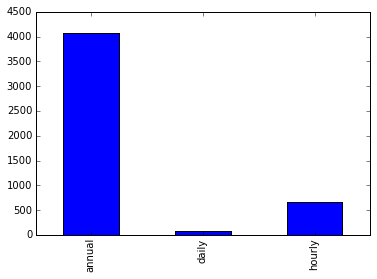

In [12]:
#remember that df2 is our dataframe with duplicate Job IDs removed.

daily_jobs = df2[df2['Salary Frequency']=='Daily']
total_daily = daily_jobs['# Of Positions'].sum()
print "There are", total_daily, "jobs with a daily pay rate."

annual_jobs = df2[df2['Salary Frequency'] == 'Annual']
total_annual = annual_jobs['# Of Positions'].sum()
print "There are", total_annual, "jobs offering an annual salary."

hourly_jobs = df2[df2['Salary Frequency'] == 'Hourly']
total_hourly = hourly_jobs['# Of Positions'].sum()
print "There are", total_hourly, "jobs with hourly pay rate."

job_type_dict = dict()
job_type_dict['daily'] = total_daily
job_type_dict['annual'] = total_annual
job_type_dict['hourly'] = total_hourly

job_type = pd.Series(job_type_dict)

%matplotlib inline

job_type.plot(kind="bar")

## Which jobs are the hardest to fill?

A few things come to mind. Remember that the columms tell us the information available to us: ['Job ID','Agency','Posting Type','# Of Positions','Business Title','Civil Service Title','Title Code No','Level','Salary Range From','Salary Range To','Salary Frequency','Work Location','Division/Work Unit','Job Description','Minimum Qual Requirements','Preferred Skills','Additional Information','To Apply','Hours/Shift','Work Location 1','Recruitment Contact','Residency Requirement','Posting Date','Post Until','Posting Updated','Process Date']

Areas to investigate:
* __Which jobs have the lowest salaries? What about the highest salaries?__ It's tough to attract job talent when you're offering a low salary, especially in NYC, where the cost of living is so high. Low salaries could prevent qualified people from applying. High salaries, on the other hand, could also be hard to fill. Perhaps a salary is high out of necessity: because a job is so demanding and unappealing. Alternatively, a high salary may indicate that the position requires more specialized knowledge and will compensate accordingly for that knowledge.
* __Which jobs have been posted for the longest amount of time?__ Our data source says that the dataset contains **current** job postings. Therefore, we can assume that if a job listing is included in the dataset, it has not yet been filled. My initial thought is that the older a job listing is, the harder it is to fill the position. But there is always the possibility that an agency just forgot to remove the job from the database after the job was filled.
* __Which jobs have the most "# Of Positions" to fill?__ I'm guessing that the more # of positions available, the harder it must be to fill a particular job.
* __Which jobs have the lengthiest "Minimum Qual Requirements" or "Preferred Skills" fields?__ Perhaps the longer these fields are, the more difficult it is to fill the position because people don't feel qualified for the position, or the hiring manager has higher standards for this position.


OK, let's get to work! First, we need to drop columns that are not relevant to our investigation and add a "Mean Salary" column so we can utilize that info.

In [13]:
job_info = nyc_jobs.drop(['Residency Requirement', 'Title Code No', 'Level', 'Work Location', \
    'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1', 'Recruitment Contact', \
    'Post Until', 'Posting Updated', 'Process Date'], axis=1)

job_info['Mean Salary'] = job_info[['Salary Range From', 'Salary Range To']].mean(axis=1)
job_info = job_info.drop_duplicates('Job ID')
annual_info = job_info[job_info['Salary Frequency'] == 'Annual']
annual_info_by_salary = annual_info.loc[:,['Agency', '# Of Positions', 'Business Title', 'Mean Salary']]
annual_info_sorted = annual_info_by_salary.sort_values('Mean Salary', ascending=True)
annual_info_sorted.head()

,Agency,# Of Positions,Business Title,Mean Salary
3648,ADMIN TRIALS AND HEARINGS,1,Customer Service Representative,28323.5
2342,DEPT OF HEALTH/MENTAL HYGIENE,4,Communications Specialist,28526.0
1727,DEPT OF HEALTH/MENTAL HYGIENE,1,Clerical Associate,28645.5
183,DEPT OF HEALTH/MENTAL HYGIENE,3,Communications Specialist,28884.0
387,DEPT OF HEALTH/MENTAL HYGIENE,1,Laboratory Helper,29437.0


## Lowest mean salaries

The lowest paying annual jobs are Cusomer Service Representatives, Communications Specialists, Clerical Associates, and Laboratory Helpers. Four out of five of these are part of the Dept of Health/Mental Hygiene (also the agency with the most openings). All of these pay a mean salary below \$30k. Pretty dire wages for living in NYC.

Now let's look at the .tail() end of that, the annual jobs that offer the highest mean salaries.

## Highest mean salaries

In [14]:
annual_info_sorted.tail()

,Agency,# Of Positions,Business Title,Mean Salary
3063,DEPT OF HEALTH/MENTAL HYGIENE,7,"Physician, Bureau of Sexually Transmitted Dise...",185965
3070,DEPT OF HEALTH/MENTAL HYGIENE,1,"Physician in Charge, Bureau of Sexually Transm...",185965
545,DEPT OF ENVIRONMENT PROTECTION,1,General Counsel,193259
543,DEPT OF ENVIRONMENT PROTECTION,1,"Deputy Commissioner, Wastewater Treatment",198518
1859,DEPT OF HEALTH/MENTAL HYGIENE,1,Deputy Chief City Medical Examiner,213000


The job with the highest mean salary is Deputy Chief City Medical Examiner. In fact, 3 of the 5 top mean salaries are medical-oriented. The other two are Physicians for Sexually Transmitted Diseases. Perhaps STDs are not a popular area of interest for doctors in government, so the city has to offer a higher salary to attract good candidates. Let's look at the job description for Deputy Chief City Medical Examiner, the only one with a mean salary upwards of \$200k.

In [15]:
nyc_jobs.loc[1859, 'Job Description']

u'Civil Service Title: Deputy Chief City Medical Examiner\t\t\t Level:  M-VII Title Code No:  95451\t\t\t\t\t\t Salary: $213,000\t\t Office Title:  N/A\t\t\t\t     \t\t Work Location: Citywide Division/Work Unit: Forensic Pathology\t\t            \t\t Number of Positions: 1 Hours/Shift: 35 hours per week; including holidays, and weekends  The Office of Chief Medical Examiner investigates cases of persons who die within New York City from criminal violence, by accident, by suicide, suddenly when in apparent health, when unattended by a physician, in a correctional facility or in any suspicious or unusual manner or where an application is made pursuant to law for a permit to cremate a body of a person and provides for the proper disposition of unclaimed bodies.  We exist to provide answers in support of families, victims, and community during time of profound need.  JOB DESCRIPTION  The core values of the OCME are to put the mission of the agency first, to be truly dedicated and to have 

That makes sense. Despite the high salary of \$213,000, the position of Deputy Chief City Medical Examiner sounds pretty grim: performing autopsies and conducting "confidential medico-legal investigations of violent, suspicious, sudden and unexpected deaths throughout the boroughs offices." 

## The oldest listings
Now let's look at the oldest listings. Remember to convert the Posting Date column to a data type of datetime by using pd.to_datetime()!

In [16]:
df2.loc[:,'Mean Salary'] = df2.loc[:,['Salary Range From', 'Salary Range To']].mean(axis=1)
df2['Posting Date'] = pd.to_datetime(df2['Posting Date'])
oldest_jobs = df2.sort_values('Posting Date', ascending=True)

oldest_jobs = oldest_jobs.loc[:,['Agency', 'Business Title', '# Of Positions', 'Mean Salary', 'Posting Date']]
oldest_jobs.head()

,Agency,Business Title,# Of Positions,Mean Salary,Posting Date
7,DEPARTMENT OF BUSINESS SERV.,Account Manager,1,53945.0,2011-06-24
8,DEPARTMENT OF BUSINESS SERV.,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",1,111377.0,2012-01-26
9,DEPT OF ENVIRONMENT PROTECTION,Project Specialist,1,47922.5,2012-06-21
11,DEPT OF ENVIRONMENT PROTECTION,Deputy Plant Chief,5,109850.0,2012-12-12
12,DEPT OF ENVIRONMENT PROTECTION,CIVIL ENGINEERING INTERN,1,47922.5,2013-02-20


The oldest listing is from 2011! The Department of Business Services may still be looking for that Account Manager, for all we know. However, I think it's safe to say that if these jobs were truly tough to fill, they would have already been reposted by now. These were probably just jobs that the agencies forgot to remove from the database once they'd filled the positions. Since I don't see particularly low mean salaries or high # Of Positions available, our sample of oldest listings doesn't seem to tell us much about the jobs that are hardest to fill. 

## The Jobs With the Highest # Of Positions Open
Now let's analyze which jobs have the highest number of positions open.

In [17]:
most_openings = df2.sort_values('# Of Positions', ascending=False)
most_openings.loc[:,['Agency', 'Business Title', '# Of Positions', 'Mean Salary', 'Posting Date']].head(10)

,Agency,Business Title,# Of Positions,Mean Salary,Posting Date
2629,ADMIN FOR CHILDREN'S SVCS,Investigate Consultant Level I,107,66521.5,2016-01-19
2160,DEPT OF HEALTH/MENTAL HYGIENE,School Mental Health Consultant,100,64267.0,2015-11-24
1259,DEPT OF HEALTH/MENTAL HYGIENE,"Nurse, Bureau of School Health",75,34.5,2015-09-04
1647,DEPT OF HEALTH/MENTAL HYGIENE,Junior Public Health Nurse (School Health),71,38.0,2015-10-19
1129,DEPT OF DESIGN & CONSTRUCTION,Construction Intern,69,51368.0,2015-09-24
1363,DEPT OF DESIGN & CONSTRUCTION,Design Intern,67,51368.0,2015-09-18
2433,DEPT OF PARKS & RECREATION,Parks Enforcement Patrol,52,37907.0,2015-12-11
33,NYC HOUSING AUTHORITY,Maintenance Worker - Technical Services-Heatin...,52,53244.0,2013-10-24
1659,DEPT OF HEALTH/MENTAL HYGIENE,"Public Health Nurse, Bureau of School Health",50,34.5,2015-10-19
50,NYC HOUSING AUTHORITY,Temporary Painter,50,35.0,2014-01-09


In [18]:
most_openings.loc[:,['Agency', 'Business Title', '# Of Positions', 'Mean Salary', 'Job Description']].head(10)

,Agency,Business Title,# Of Positions,Mean Salary,Job Description
2629,ADMIN FOR CHILDREN'S SVCS,Investigate Consultant Level I,107,66521.5,The Protection Agent will be involved primaril...
2160,DEPT OF HEALTH/MENTAL HYGIENE,School Mental Health Consultant,100,64267.0,The Office of School Health (OSH) is a joint P...
1259,DEPT OF HEALTH/MENTAL HYGIENE,"Nurse, Bureau of School Health",75,34.5,**OPEN TO PERMANENT PUBLIC HEALTH NURSES ONLY....
1647,DEPT OF HEALTH/MENTAL HYGIENE,Junior Public Health Nurse (School Health),71,38.0,** 30 - 35 Hours/Week - Part-time The Bure...
1129,DEPT OF DESIGN & CONSTRUCTION,Construction Intern,69,51368.0,"The NYC Department of Design and Construction,..."
1363,DEPT OF DESIGN & CONSTRUCTION,Design Intern,67,51368.0,The selected candidates will receive hands-on ...
2433,DEPT OF PARKS & RECREATION,Parks Enforcement Patrol,52,37907.0,The Parks Enforcement Patrol (PEP) provides a ...
33,NYC HOUSING AUTHORITY,Maintenance Worker - Technical Services-Heatin...,52,53244.0,"Under direct supervision, assist in the routin..."
1659,DEPT OF HEALTH/MENTAL HYGIENE,"Public Health Nurse, Bureau of School Health",50,34.5,**30-35 hours/week -Part-time OPEN TO PERMANE...
50,NYC HOUSING AUTHORITY,Temporary Painter,50,35.0,Responsibilities of selected candidates will i...


Let's look at the description for the position most in demand, "Investigate Consultant Level 1."

In [19]:
print most_openings.loc[2629, 'Job Description']

The Protection Agent will be involved primarily in, complex and sensitive investigations related to children in the custody of ACS, including investigating allegations of child abuse and neglect, helping locate youth who have left or who are missing from foster care or DYFJ non-secure detention and/or placement facilities, and advising and training Child Protective Specialists (CPS), Child Protective Specialist Supervisors (CPSS) and other child protective staff in techniques and approaches for handling such cases in ChildrenÃ¢â¬â¢s Services.  Under supervision, with latitude for independent action and decision-making, is assigned to a child protective field office or special investigation unit, such as Emergency ChildrenÃ¢â¬â¢s Services or the Office of Special Investigation.  Additional responsibilities will include:  Ã¢â¬Â¢	Provide expert assistance on cases which involves allegations of child abuse or neglect by parents, by ChildrenÃ¢â¬â¢s Services or other City staff, which

Sounds like quite a demanding and emotionally taxing job, working with troubled and/or missing children. No wonder it's a tough position to fill! Let's look at the job description of the job with almost as many openings, School Mental Health Consultant.

In [20]:
print most_openings.loc[2160, 'Job Description']

The Office of School Health (OSH) is a joint Program of the Department of Education and the Department of Health and Mental Hygiene responsible for promoting the health of over one (1) million school children enrolled in approximately 1,700 public and non 'public schools in the New York City. Services to students include case management of chronic health problems, preventive health screening, urgent care, medication administration, preventive counseling, health education, referral for care and assurance of ongoing effective treatment.   The School Mental Health Consultant is responsible for assisting in arranging, coordinating, and implementing the initiativeÃ¢â¬â¢s strategies, services, and resources in consultation with the Office of School Health, Director of School Mental Health Consultation Program.  The SMHCPDD participates in the development and implementation of the School Mental Health Consultant Program as part of the NYC DOE Mental Health Roadmap consistent with the expect

This also looks like a job that has a lot of responsibilities that involve troubled youth. No wonder there are so many positions open!

## Length of Job Requirements field

Is it harder to fill a job if you list too many requirements or preferred skills? Let's find out. First let's create a new column that finds the character count of the Minimum Qual Requirements column. Let's do the same for the character count in Preferred Skills.

In [21]:
annual_info_reqs = annual_info.loc[:,['Agency', '# Of Positions', 'Business Title', 'Mean Salary', 'Minimum Qual Requirements','Preferred Skills']]
annual_info_reqs_sorted = annual_info_reqs.sort_values('# Of Positions', ascending=False)
annual_info_reqs_sorted['Reqs Character Count'] = annual_info_reqs_sorted['Minimum Qual Requirements'].str.len()
annual_info_reqs_sorted['Skills Character Count'] = annual_info_reqs_sorted['Preferred Skills'].str.len()

annual_most_demanding_reqs = annual_info_reqs_sorted.sort_values('Reqs Character Count', ascending=False)
annual_most_demanding_reqs.head()

,Agency,# Of Positions,Business Title,Mean Salary,Minimum Qual Requirements,Preferred Skills,Reqs Character Count,Skills Character Count
1021,DEPT OF DESIGN & CONSTRUCTION,3,Regulatory Manager,73133.0,1. A four-year high school diploma or its educ...,The position requires excellent communication ...,3377,74
1116,DEPT OF DESIGN & CONSTRUCTION,4,Construction Project Manager,85630.0,1. A four-year high school diploma or its educ...,Experience in construction and construction ad...,3377,383
680,DEPARTMENT OF TRANSPORTATION,1,Urban Infrastructure Project manager,62922.0,1. A four-year high school diploma or its educ...,"Good communication, writing skills. Microsoft ...",3377,192
2217,HOUSING PRESERVATION & DVLPMNT,1,Construction Project Manager L2,74961.5,1. A four-year high school diploma or its educ...,PREFERED SKILL(S) Ã¢â¬Â¢\tBi-lingual. NOTE: ...,3377,102
486,DEPT OF DESIGN & CONSTRUCTION,8,Resident Engineer,73133.0,1. A four-year high school diploma or its educ...,"Candidates with roadway, sewer, and/or waterma...",3377,383


In [22]:
annual_most_demanding_skills = annual_info_reqs_sorted.sort_values('Skills Character Count', ascending=False)
annual_most_demanding_skills.head()

,Agency,# Of Positions,Business Title,Mean Salary,Minimum Qual Requirements,Preferred Skills,Reqs Character Count,Skills Character Count
1451,DEPT OF INFO TECH & TELECOMM,2,Senior QA Analyst,84607.5,(1) A baccalaureate degree from an accredited ...,We are looking for a candidate who not only ha...,2226,4144
1390,DEPT OF INFO TECH & TELECOMM,2,Quality Assurance Lead,102191.5,(1) A baccalaureate degree from an accredited ...,We are looking for a candidate who not only ha...,2353,3883
1449,DEPT OF INFO TECH & TELECOMM,3,QA Analyst,77403.5,(1) A baccalaureate degree from an accredited ...,We are looking for a candidate who not only ha...,2226,3503
2557,FINANCIAL INFO SVCS AGENCY,1,ARCHITECT / DEVELOPER,100000.0,1. A master's degree in computer science from ...,Ã¢â¬Â¢ Strong knowledge of Web development ar...,1965,3206
2781,DEPT OF INFO TECH & TELECOMM,1,IT Operations Center Manager (Nights),83746.0,1. Six (6) years of progressively responsible ...,Ã¢â¬Â¢Extensive enterprise incident managemen...,896,2835


So it doesn't look like the jobs with the longest skills or requirements have low salaries or lots of positions open. This leads me to believe that the hardest jobs to fill are the ones with __difficult (rather than lengthy)__ job descriptions, a high # of positions open, and salaries that aren't especially high.

Based on the above, I think that the most difficult jobs to fill are the jobs that have the most openings & lowest salaries: __Investigate Consultant Level 1 for the Admin for Children's Services, and School Mental Health Consultant for the Department of Health/Mental Hygiene.__ These jobs also sound like a lot of responsibility for not a lot of pay (but arguably still more pay than the Dept of Cultural Affairs' mean salary).

## Summary

1. The Department of Health/Mental Hygiene has the most openings.
2. From our analysis of current job openings, even though the Office of Management and Budget technically offers the highest mean annual salary, since it only has one position open, it's not necessarily indicative of the agency's salaries as a whole. With 66 annually paid job openings, the Department of Sanitation seems to offer potential candidates the highest annual salaries. The Fire Department offers the highest hourly and daily salaries. The lowest annual salaries go to the Dept of Parks and Recreation. Though this agency is not the lowest on the list, it has the most openings, and is therefore more likely to be indicative of the agency's salaries as a whole when compared to other agencies with low salaries but also a small number of openings. The lowest hourly rate goes to the Office of Collective Bargaining, at \$9.50/hr. The Dept of Citywide Administrative Services offers the lowest daily pay rate.

3. Based on the theory that jobs with a) the most openings and b) salaries that aren't especially high are harder to fill, the hardest jobs to fill are: Investigate Consultant Level 1 for the Admin for Children's Services, and School Mental Health Consultant for the Department of Health/Mental Hygiene. 